# EDA y procesamiento de datos.

### Configuraciones Iniciales y Lectura de Datos

In [5]:
import sys
import os
import pandas as pd
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np

# Configuración para visualizar todas las columnas
pd.set_option('display.max_columns', None)

# Ruta a la carpeta de scripts
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

# Cargar los datos procesados
df = pd.read_parquet(r'D:\Henry Data Science\Proyecto_individual_1\Data\movies_dataset.parquet')
genres_desanidado = pd.read_parquet(r'D:\Henry Data Science\Proyecto_individual_1\Data\genres_desanidado.parquet')
pc_desanidado = pd.read_parquet(r'D:\Henry Data Science\Proyecto_individual_1\Data\pc_desanidado.parquet')


ModuleNotFoundError: No module named 'seaborn'

### Análisis Exploratorio de Datos (EDA)
### Duración de las Películas
- Limpieza de datos: Reemplazo de valores nulos y 0 con la mediana.

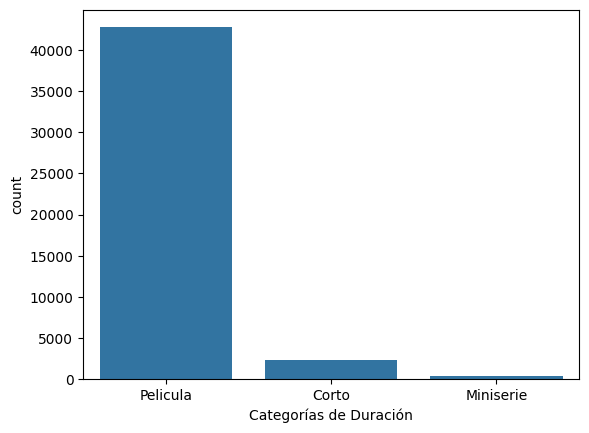

In [23]:
# Reemplazar valores nulos y 0 en 'runtime' con la mediana
mediana = int(df['runtime'].median())
df['runtime'] = df['runtime'].fillna(mediana).replace(0, mediana)

# Categorizar según duración
condicion = [
    (df['runtime'] < 60),  # Corto
    (df['runtime'] >= 60) & (df['runtime'] <= 200),  # Película
    (df['runtime'] > 200)  # Miniserie
]
eleccion = ['Corto', 'Pelicula', 'Miniserie']
df['runtime'] = pd.Series(np.select(condicion, eleccion, default='Desconocido')).astype(str)

# Visualización de categorías
sns.countplot(data=df, x='runtime')
plt.xlabel('Categorías de Duración')
plt.show()

### Año de estreno.
- Filtrar datos irrelevantes por antigüedad (año < 1975).

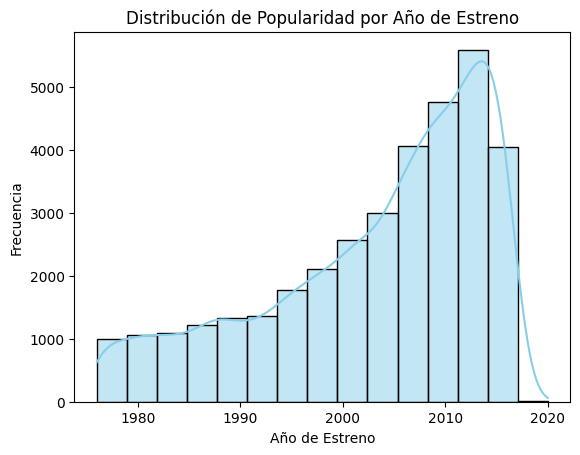

In [24]:
# Asegurarse de que 'release_date' esté en el formato correcto
df['release_date'] = pd.to_datetime(df['release_date'], format='%Y-%m-%d', errors='coerce')

# Eliminar filas con valores nulos en 'release_date'
df = df.dropna(subset=['release_date'])

# Crear la columna 'release_year' a partir de 'release_date'
df['release_year'] = df['release_date'].dt.year

# Filtrar datos según relevancia temporal
df = df[df['release_year'] > 1975]

# Visualización de popularidad por año

sns.histplot(df, x='release_year', bins=15, kde=True, color='skyblue')
plt.title('Distribución de Popularidad por Año de Estreno')
plt.xlabel('Año de Estreno')
plt.ylabel('Frecuencia')
plt.show()

### Idiomas.
- Filtrar por idiomas relevantes (español e idiomas predominantes).

In [25]:
# Filtrar datos según idiomas relevantes
idiomas = ['es', 'en', 'fr', 'it', 'de']
df = df[df['original_language'].isin(idiomas)]

# Verificar si 'spoken_languages_id' existe antes de eliminarla
if 'spoken_languages_id' in df.columns:
    df = df.drop(['spoken_languages_id'], axis=1)
else:
    print("La columna 'spoken_languages_id' no existe en el DataFrame.")

# Verificar las dimensiones del DataFrame después de los cambios
print(f"Dimensiones del DataFrame: {df.shape}")
print(df.head())

La columna 'spoken_languages_id' no existe en el DataFrame.
Dimensiones del DataFrame: (28976, 25)
   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                               None  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                               None  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862

### Transformaciones logarítmicas.
- Para normalizar distribuciones sesgadas como popularidad y votos.

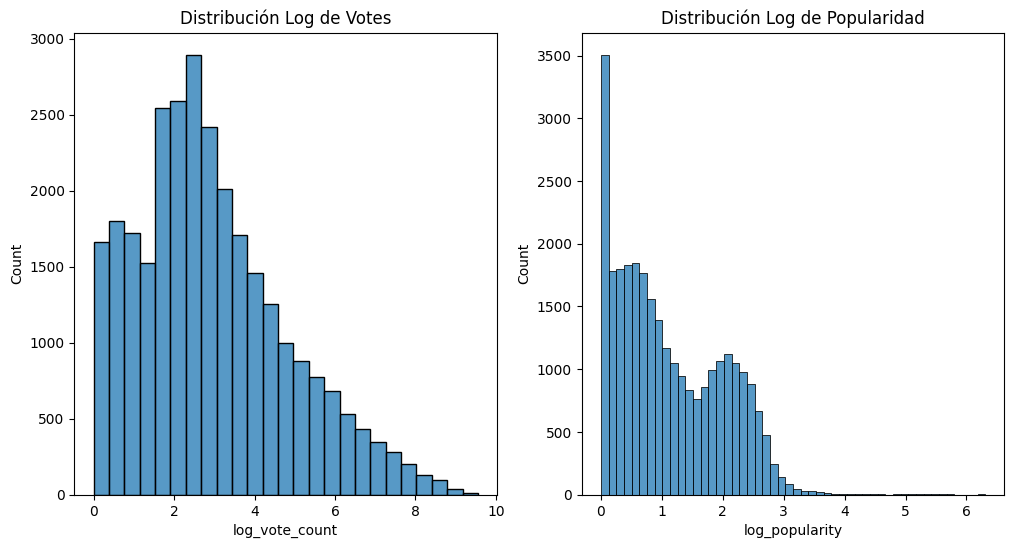

In [26]:
df['log_vote_count'] = np.log1p(df['vote_count'])
df['log_popularity'] = np.log1p(df['popularity'])

# Visualización
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data=df, x='log_vote_count', bins=25, ax=ax[0])
sns.histplot(data=df, x='log_popularity', bins=50, ax=ax[1])
ax[0].set_title('Distribución Log de Votes')
ax[1].set_title('Distribución Log de Popularidad')
plt.show()

### Correlaciones financieras.
- Matriz de correlación para identificar relaciones clave entre variables.

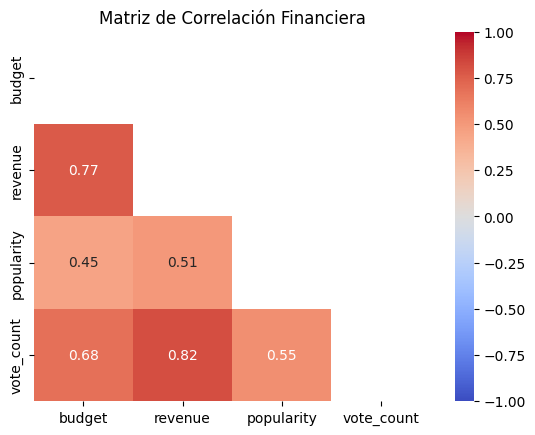

KeyError: "['return'] not found in axis"

In [27]:
# Selección de columnas para correlación
df_corr = df[['budget', 'revenue', 'popularity', 'vote_count']]
corr = df_corr.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', mask=np.triu(np.ones_like(corr, dtype=bool)), vmin=-1, vmax=1)
plt.title('Matriz de Correlación Financiera')
plt.show()

# Decisión: Eliminar columnas menos relevantes
df = df.drop(['return', 'budget', 'log_vote_count', 'log_popularity'], axis=1)

## Enriquecimiento de datos.
### Descripción.
- Limpieza y preprocesamiento de texto para enriquecer las descripciones.

In [2]:
from tokenize_1 import preprocess_text
df['overview'] = df['overview'].apply(preprocess_text)
df = df[df['overview'].str.strip() != ""]

ModuleNotFoundError: No module named 'tokenize_1'

### Productoras y géneros.
- Agregar información enriquecida de productoras y géneros a la columna .

In [3]:
from normalize import normalizar_texto

# Normalizar y agrupar productoras
pc_desanidado['name'] = pc_desanidado['name'].apply(normalizar_texto)
company_names = pc_desanidado.groupby('production_companies_id')['name'].apply(' '.join).reset_index()
df = df.merge(company_names, on='production_companies_id', how='left')
df = df.drop('production_companies_id', axis=1)

# Normalizar y agrupar géneros
genres_desanidado['name'] = genres_desanidado['name'].apply(normalizar_texto)
generos = genres_desanidado.groupby('genres_id')['name'].apply(' '.join).reset_index()
df = df.merge(generos, on='genres_id', how='left')
df = df.drop('genres_id', axis=1)

ModuleNotFoundError: No module named 'normalize'

### Actores.
- Agregar nombres de actores relevantes a la columna .

In [4]:
cast_df = pd.read_parquet(r'D:\Henry Data Science\Proyecto_individual_1\Data\cast_desanidado.parquet')
cast_df['name'] = cast_df['name'].apply(normalizar_texto)
actores = cast_df.groupby('id_df')['name'].apply(' '.join).reset_index()
df = df.merge(actores, on='id', how='left')

NameError: name 'pd' is not defined

### Construcción final de predictores.
- Unir columnas enriquecidas (overview, productoras, géneros, actores) en un predictor final.

In [3]:
from add_weight import add_weight

df['predictor'] = df.apply(lambda row: add_weight(row, 'combined_companies', weight=1), axis=1)
df['predictor'] = df.apply(lambda row: add_weight(row, 'generos', weight=2), axis=1)
df['predictor'] = df.apply(lambda row: add_weight(row, 'actores', weight=1), axis=1)

# Selección final de columnas
df = df[['title', 'predictor']]

ModuleNotFoundError: No module named 'add_weight'

## Exportación del dataset final.

In [2]:
# Exportar el DataFrame procesado
output_dir = '../Datasets/'
os.makedirs(output_dir, exist_ok=True)
parquet_path = os.path.join(output_dir, 'modelo_dataset.parquet')
df.to_parquet(parquet_path, engine='pyarrow', compression='snappy', index=False)

print("Datos exportados correctamente a 'Datasets'")

NameError: name 'os' is not defined